In [ ]:
!pip install num2words
!pip install emoji

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 6.1 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=983d7719cf1aa5870953c1a66ad4a98907782a6569d379452c09e8f0e402a77a
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 14.5 MB/s eta 0:00:00


In [ ]:
import re, random
import numpy as np
import nltk
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

from sklearn.metrics import recall_score, cohen_kappa_score, accuracy_score, log_loss
from sklearn.preprocessing import label_binarize
import math

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from num2words import num2words
import emoji

nltk.download('stopwords')
MODEL_NAME = "xlm-roberta-base"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)



--- RUNNING HYPOTHESIS TEST: Untrained Embedding Analysis ---
Loading Target Data (Arabic) for zero-shot check...
Loading raw XLM-R...
Extracting embeddings...
Calculating t-SNE (this might take a moment)...
Saved plot to 'hypothesis_check_untrained.png'
--- TEST COMPLETE: Starting Normal Training Pipeline ---



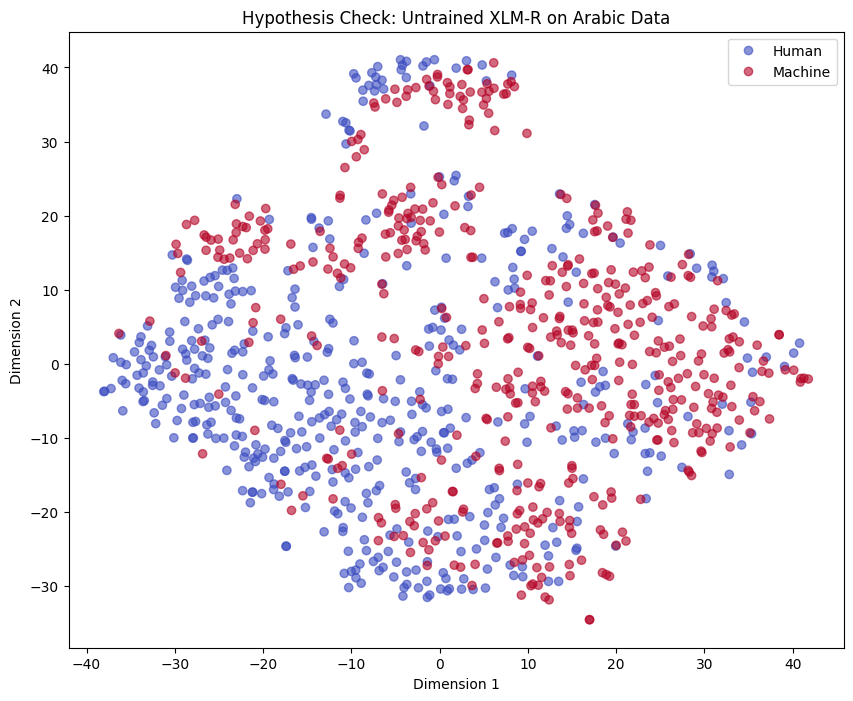

In [ ]:
# ==================================================================================
# HYPOTHESIS TEST: Zero-Shot Clustering Check (Untrained XLM-R)
# Purpose: Check if "Human vs Machine" is already separated in the pre-trained model.
# ==================================================================================
print("\n--- RUNNING HYPOTHESIS TEST: Untrained Embedding Analysis ---")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Load the TARGET Data (Arabic) first to check it
# Note: We use the same cleaning functions defined later, so we define a quick temp cleaner here
def temp_clean(text):
    text = str(text).strip()
    text = re.sub(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+', ' ', text) # Remove URLs/Handles
    return text

print("Loading Target Data (Arabic) for zero-shot check...")
df_target = pd.read_csv('ground_truth.csv') # The ARABIC dataset
df_target = df_target.drop(columns=['id'])
df_target["label"] = df_target["label"].map({"human": 0, "machine": 1})

# Sample 500 from each class to keep plot clean and fast
df_h = df_target[df_target['label']==0].sample(n=500, random_state=42)
df_m = df_target[df_target['label']==1].sample(n=500, random_state=42)
df_viz = pd.concat([df_h, df_m]).reset_index(drop=True)

# 2. Load Raw Model (No Classification Head)
print("Loading raw XLM-R...")
temp_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
temp_model = AutoModel.from_pretrained(MODEL_NAME).to(torch.device("cuda"))
temp_model.eval()

# 3. Extract Embeddings
print("Extracting embeddings...")
embeddings = []
labels_viz = df_viz['label'].tolist()
texts_viz = df_viz['content'].astype(str).apply(temp_clean).tolist()

batch_size_viz = 32
with torch.no_grad():
    for i in range(0, len(texts_viz), batch_size_viz):
        batch_txt = texts_viz[i:i+batch_size_viz]
        inputs = temp_tokenizer(batch_txt, return_tensors="pt", padding=True, truncation=True, max_length=128).to(torch.device("cuda"))
        outputs = temp_model(**inputs)
        # Use CLS token (index 0)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

X_viz = np.vstack(embeddings)

# 4. t-SNE Projection
print("Calculating t-SNE (this might take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_viz)

# 5. Save the Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_viz, cmap='coolwarm', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['Human', 'Machine'])
plt.title("Hypothesis Check: Untrained XLM-R on Arabic Data")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.savefig("hypothesis_check_untrained.png")
print("Saved plot to 'hypothesis_check_untrained.png'")
print("--- TEST COMPLETE: Starting Normal Training Pipeline ---\n")
# ==================================================================================

In [ ]:
df = pd.read_csv('urdu_train.csv')
stopwords_arabic = set(stopwords.words('arabic'))

# Arabic Text Cleaning Functions
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def normalize_urdu(text):
    text = text.replace('ی', 'ی')
    text = text.replace('ء', '')
    text = text.replace('ئ', 'ی')
    text = text.replace('ة', 'ہ')
    text = text.replace('أ', 'ا').replace('إ', 'ا').replace('آ', 'ا')
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def numbers_to_arabic_words(text):
    def replace(match):
        num = int(match.group())
        return num2words(num, lang='ar')
    return re.sub(r'\d+', replace, text)

def clean_text(text):
    text = str(text).strip()
    text = remove_emojis(text)
    text = remove_urls_handles(text)
    text = remove_tatweel(text)
    text = normalize_urdu(text)
    text = normalize_whitespace(text)
    return text

cleaned_texts = df["text"].astype(str).apply(clean_text).tolist()
labels = torch.tensor(df['label'].values, dtype=torch.long)

# Tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

In [ ]:
# Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

model = BertClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

for param in model.bert.embeddings.parameters():
    param.requires_grad = False
N_FREEZE = 6
for layer in model.bert.encoder.layer[:N_FREEZE]:
    for param in layer.parameters():
        param.requires_grad = False

for epoch in range(5):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == batch_labels).sum().item()
        train_total += batch_labels.size(0)

    train_acc = train_correct / train_total

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")


/tmp/ipython-input-3743962911.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch 1 | Train Loss: 80.4884 | Train Acc: 0.9093
Epoch 2 | Train Loss: 21.6713 | Train Acc: 0.9825
Epoch 3 | Train Loss: 14.0225 | Train Acc: 0.9879
Epoch 4 | Train Loss: 10.5140 | Train Acc: 0.9906
Epoch 5 | Train Loss: 8.1076 | Train Acc: 0.9934


In [ ]:
# Testing on a arabic dataset

In [ ]:
class InferenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=max_length
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item


In [ ]:
test_arabic = pd.read_csv("ground_truth.csv")
test_arabic = test_arabic.drop(columns=['id'])

label_map = {"human": 0, "machine": 1}
test_arabic["label"] = test_arabic["label"].map(label_map)

test_arabic = test_arabic.sample(frac=1, random_state=42).reset_index(drop=True)

def clean_text(text):
    text = str(text).strip()
    text = remove_emojis(text)
    text = remove_urls_handles(text)
    text = normalize_arabic(text)
    text = remove_tatweel(text)
    text = normalize_whitespace(text)
    return text

arabic_dataset = InferenceDataset(
    texts=test_arabic["content"].astype(str).apply(clean_text).tolist(),
    labels=test_arabic["label"].values,
    tokenizer=tokenizer
)

arabic_loader = DataLoader(
    arabic_dataset,
    batch_size=32,
    shuffle=False
)

model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in arabic_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        batch_preds = torch.argmax(outputs, dim=1)

        preds.extend(batch_preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [ ]:
print("Classification Report:")
print(classification_report(
    true_labels,
    preds,
    target_names=["human", "machine"],
    digits=3
))
print("Macro F1:", f1_score(true_labels, preds, average="macro"))

preds_np = np.array(preds)
true_np = np.array(true_labels)

macro_f1 = f1_score(true_np, preds_np, average="macro")
macro_recall = recall_score(true_np, preds_np, average="macro")
print(f"\n\nMacro F1: {macro_f1:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

report_dict = classification_report(true_np, preds_np, output_dict=True)
# Map numeric keys to label names
label_map_rev = {0: "human", 1: "machine"}
per_class_f1 = [report_dict[str(k)]["f1-score"] for k in [0,1]]
f1_variance = np.var(per_class_f1)
print(f"\n\nPer-class F1: {per_class_f1}")
print(f"F1 Variance: {f1_variance:.6f}")

kappa = cohen_kappa_score(true_np, preds_np)
print(f"\n\nCohen's Kappa: {kappa:.4f}")

# Need probabilities from softmax
probs = []
with torch.no_grad():
    for batch in urdu_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids, attention_mask)
        prob_batch = torch.softmax(outputs, dim=1).cpu().numpy()
        probs.extend(prob_batch)
probs = np.array(probs)
# Brier score for binary
brier = np.mean((probs[:,1] - true_np) ** 2)
print(f"\n\nBrier Score: {brier:.6f}")

def compute_ece(probs, labels, n_bins=10):
    bin_edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_lower, bin_upper = bin_edges[i], bin_edges[i+1]
        mask = (probs[:,1] > bin_lower) & (probs[:,1] <= bin_upper)
        if np.any(mask):
            bin_conf = np.mean(probs[:,1][mask])
            bin_acc = np.mean(labels[mask])
            ece += (np.sum(mask)/len(labels)) * abs(bin_conf - bin_acc)
    return ece

ece = compute_ece(probs, true_np)
print(f"\n\nExpected Calibration Error (ECE): {ece:.6f}")

cm = confusion_matrix(true_np, preds_np)
print("\n\nConfusion Matrix:\n", cm)

# Confusion entropy per class
def confusion_entropy(cm):
    entropies = []
    for i in range(len(cm)):
        row = cm[i]
        probs_row = row / row.sum() if row.sum() > 0 else np.zeros_like(row)
        entropy = -np.sum([p*math.log2(p) for p in probs_row if p > 0])
        entropies.append(entropy)
    return entropies

entropies = confusion_entropy(cm)
print(f"Confusion Entropy per class: {entropies}")

acc = accuracy_score(true_np, preds_np)
print(f"\n\nAccuracy: {acc:.4f}")

Classification Report:
              precision    recall  f1-score   support

       human      0.923     0.213     0.347      2649
     machine      0.555     0.982     0.709      2649

    accuracy                          0.598      5298
   macro avg      0.739     0.598     0.528      5298
weighted avg      0.739     0.598     0.528      5298

Macro F1: 0.5279972959227507


Macro F1: 0.5280
Macro Recall: 0.5978


Per-class F1: [0.34651947255443116, 0.7094751192910702]
F1 Variance: 0.032934


Cohen's Kappa: 0.1955


Brier Score: 0.367203


Expected Calibration Error (ECE): 0.368231


Confusion Matrix:
 [[ 565 2084]
 [  47 2602]]
Confusion Entropy per class: [np.float64(0.7477208655669223), np.float64(0.1285706984003687)]


Accuracy: 0.5978



--- RUNNING HYPOTHESIS TEST 2: Trained Model on Arabic ---
Extracting embeddings from TRAINED model...
Calculating t-SNE for trained model...
Saved plot to 'hypothesis_check_TRAINED.png'
--- HYPOTHESIS TEST 2 COMPLETE ---


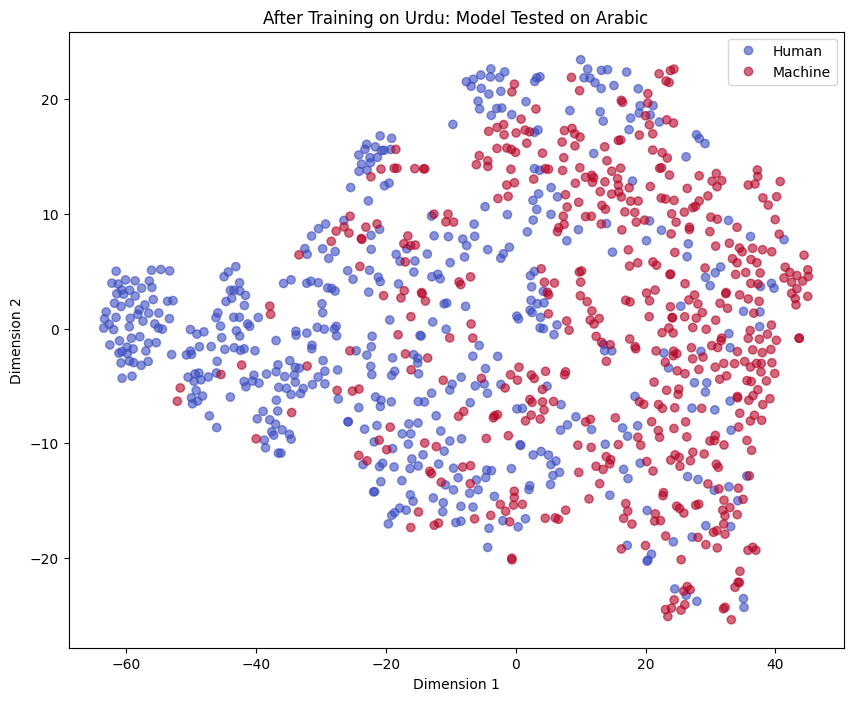

In [ ]:
# ==================================================================================
# HYPOTHESIS TEST PART 2: Trained Embedding Analysis (The "After" Shot)
# Purpose: See if Urdu training separated the Arabic clusters.
# ==================================================================================
print("\n--- RUNNING HYPOTHESIS TEST 2: Trained Model on Arabic ---")

# 1. Re-load the Arabic Data (Same subset as before to be fair)
# We use the same 'df_viz' logic as the first test
df_target_after = pd.read_csv('ground_truth.csv')
df_target_after = df_target_after.drop(columns=['id'])
df_target_after["label"] = df_target_after["label"].map({"human": 0, "machine": 1})

# Sample 500 from each class (Same as before)
df_h = df_target_after[df_target_after['label']==0].sample(n=500, random_state=42)
df_m = df_target_after[df_target_after['label']==1].sample(n=500, random_state=42)
df_viz_after = pd.concat([df_h, df_m]).reset_index(drop=True)

# 2. Extract Embeddings using the TRAINED model
print("Extracting embeddings from TRAINED model...")
embeddings_after = []
labels_after = df_viz_after['label'].tolist()
texts_after = df_viz_after['content'].astype(str).apply(clean_text).tolist() # Use the main cleaning function

model.eval() # Set to eval mode

batch_size_viz = 32
with torch.no_grad():
    for i in range(0, len(texts_after), batch_size_viz):
        batch_txt = texts_after[i:i+batch_size_viz]

        # Use the global tokenizer and device
        inputs = tokenizer(batch_txt, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        # Pass through the BERT part of your classifier
        # Note: Your model is wrapped in 'BertClassifier', so we access 'model.bert'
        outputs = model.bert(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

        # Get CLS token
        cls_rep = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings_after.append(cls_rep)

X_viz_after = np.vstack(embeddings_after)

# 3. t-SNE Projection
print("Calculating t-SNE for trained model...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded_after = tsne.fit_transform(X_viz_after)

# 4. Save the Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded_after[:, 0], X_embedded_after[:, 1], c=labels_after, cmap='coolwarm', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['Human', 'Machine'])
plt.title("After Training on Urdu: Model Tested on Arabic")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.savefig("hypothesis_check_TRAINED.png")
print("Saved plot to 'hypothesis_check_TRAINED.png'")
print("--- HYPOTHESIS TEST 2 COMPLETE ---")